#  Enhancing Deployment-time Predictive Model Robustness for Code Analysis and Optimization: Artifacts Evaluation Instructions

## Preliminaries

This interactive Jupyter notebook provides a small-scale demo showcasing the evaluation of case studies reported in the paper.

The main results of our CGO 2025 paper demonstrate the application of Prom across five case studies for detecting drifting samples. The full evaluation, presented in our paper, was conducted on a much larger dataset over a longer runtime. This notebook contains minimal working examples, designed to be evaluated within a reasonable amount of time (approximately 2 hours).

## Instructions for Experimental Workflow:

Before starting. Go to the landing page, select the checkbox next to the notebook titled *main.ipynb*, and then click "**Duplicate**".

Click the name of the newly created Jupyter Notebook, e.g. **AE-Copy1.ipynb**. Next, select "**Kernel**" > "**Restart & Clear Output**". Next, repeatedly press the play button (the tooltip is "run cell, select below") to step through each cell of the notebook.

Alternatively, you can select each cell in turn and use "**Cell**"> "**Run Cell**" from the menu to run specific cells. Note that some cells depend on previous cells being executed. If any errors occur, ensure that all previous cells have been run.

## Important Notes

**Some cells can take more than 30 minutes to complete; please wait for the results until step to the next cell.**

High load can lead to a longer wait times for results, particularly if multiple reviewers are generating results simulataneously.

The experiments are customisable, as the code withinin the Jupyter Notebook can be editeddirectly. Simply type your changes into the code blocks and re-run them using **Cell > Run Cells** from the menu.

## Links to The Paper

For each step, we note the section number of the submitted version where the relevant technique is described or data is presented.

The main results are presented in Figures 7-10 and Table 2 and 3 of the submitted paper.

# Demo 1: Tutorial for Prom

This demo corresponds to the simplified drifting detection example shown in Figure 2. This small-scale demo represents case study 1 on thread coarsening. Note that the code has been refactored, resulting in minor changes to the API.

## Step 1. Train the underlying model

This problem involves developing a model to determine the optimal OpenCL GPU thread coarsening factor for performance optimization. Following the original paper, an ML model predicts a coarsening factor (ranging from 1 to 32) for a test OpenCL kernel, where 1 indicates no coarsening. Following the setup of DeepTune, we train and test the models on their labeled dataset, which includes 17 OpenCL kernels from three benchmark suites across four GPU platforms (this minimal working example runs on the Titan platform).

We train the baseline model using leave-one-out cross-validation, where the model is trained on 16 OpenCL kernels and tested on the remaining one.
#### Training dataset and calibration dataset partitioning

In [1]:
!cd /cgo/prom/PROM/examples/tutorial
!bash ae_tu.sh
# import sys
# print(sys.version)
# print(sys.executable)
# !conda info --env

import os
import sys

os.environ["TOKENIZERS_PARALLELISM"] = "false"
sys.path.append('/cgo/prom/PROM')
sys.path.append('../case_study/Thread/')
sys.path.append('/cgo/prom/PROM/src')
sys.path.append('/cgo/prom/PROM/thirdpackage')

from Magni_utils import ThreadCoarseningMa, Magni, make_predictionMa, make_prediction_ilMa
from Thread_magni import load_magni_args_notebook, load_magni_args
from src.prom.prom_util import Prom_utils

print("Starting to partition the training and calibration datasets...")

# Load necessary arguments for the program, related to model configuration or runtime settings
args = load_magni_args()
seed_value = int(args.seed)

# Initialize a thread coarsening model using the approach in Magni et al
prom_thread = ThreadCoarseningMa(model=Magni())

# Define the path to the dataset and the target platform (here, "Tahiti" refers to a GPU architecture or hardware)
dataset_path = "../../benchmark/Thread"
platform = "Tahiti"

# Perform data partitioning for training, validation, and testing
# returns the split data, including features (X) and labels (y)
# returns calibration data and indices for each partition (train, validation, and test).
# args can contain data partitioning hyperparameters (such as shuffle, split ratios, etc.)

split_data = prom_thread.data_partitioning(
    dataset_path, platform=platform, mode='train', calibration_ratio=0.1, args=args
)
(
    X_cc, y_cc,               # The coarsened features and labels (thread coarsening context)
    train_x, valid_x, test_x, # Training, validation, and testing features (input data)
    train_y, valid_y, test_y, # Training, validation, and testing labels (output data)
    calib_data, calib_y,      # Calibration data and labels, for model tuning or confidence calibration
    train_index, valid_index, test_index, # Indexes for the split datasets (training, validation, test)
    y, X_seq, y_1hot          # Other data representations (e.g., one-hot encoding, sequence features/labels)
) = split_data

print("Data splitting process completed!")

Environment activated.
Starting to partition the training and calibration datasets...
Data splitting process completed!


#### Training the underlying model


In [2]:
print("Starting the training process for the underlying model...")

# Initialize the model
# 'args' can contain model hyperparameters (e.g., learning rate, batch size, etc.)
prom_thread.model.init(args)

# Train the model using training data (features and labels)
prom_thread.model.train(
    cascading_features=train_x, # train data features (possibly related to thread coarsening features)
    verbose=True,               # detailed training process output including progress
    cascading_y=train_y         # train data labels
)

origin_speedup_all = [] # original speedup values
speed_up_all = []       # predicted speedup values
improved_spp_all = []   # speedup improvement values (original speedup - retrained speedup)

# Make predictions using the trained model
origin_speedup, all_pre, data_distri = make_predictionMa(
    speed_up_all=speed_up_all,    # speedup predictions from the model (list)
    platform=platform,            # target platform (e.g., "Tahiti") used for prediction
    model=prom_thread.model,      # trained model
    test_x=test_x,                # test data features
    test_index=test_index,        # test data indices
    X_cc=X_cc                     # additional features (possibly coarsened or cascading features)
)

print(f"Thread coarsening speedup on platform '{platform}' is {origin_speedup:.2%}")

Starting the training process for the underlying model...
Thread coarsening speedup on platform 'Tahiti' is 93.14%


#### Training the anomaly detector

In [3]:
print("Starting the construction of the anomaly detector...")

# trained classifier model
clf = prom_thread.model

# prom parameters (method_params) for different evaluation metrics
method_params = {
    "lac": ("score", True),
    "top_k": ("top_k", True),
    "aps": ("cumulated_score", True),
    "raps": ("raps", True)
}

# Prom object for performing conformal prediction and evaluation
# 'task' : set to "thread" to model thread coarsening task
Prom_thread = Prom_utils(clf, method_params, task="thread")

# Perform conformal prediction
y_preds, y_pss, p_value = Prom_thread.conformal_prediction(
    cal_x=calib_data, cal_y=calib_y, # calibration data and labels
    test_x=test_x, test_y=test_y,    # test data and labels
    significance_level="auto"        # set to "auto" for automatic adjustment
)
print("The anomaly detector has been successfully constructed.")

Starting the construction of the anomaly detector...
The anomaly detector has been successfully constructed.


# Train the Prom anolamy detector

## Step 2. Prom on deployment

First, to introduce data drift, we train the ML models on OpenCL benchmarks from two suites and then test the trained model on another left-out benchmark suite.

#### Native deployment



In [4]:
# Load pre-trained model for predictions
prom_thread.model.restore(r'../../examples/case_study/Thread/ae_savedmodels/tutorial/Tahiti-underlying.model')

# Make predictions on test data
origin_speedup, all_pre, data_distri = make_predictionMa(
    speed_up_all=speed_up_all,    # Array or list of speed-up values for the model
    platform=platform,            # Target platform for prediction (e.g., CPU, GPU)
    model=prom_thread.model,      # Loaded model used for making predictions
    test_x=test_x,                # Test features or data input for predictions
    test_index=test_index,        # Indices for test data to match predicted values
    X_cc=X_cc                     # Contextual data or additional features for prediction
)

# Print a success message with the deployment speedup result
print(f"Deployment speedup on platform '{platform}' is {origin_speedup:.2%}")

# Calculate average from all speed-up values
origin = sum(speed_up_all) / len(speed_up_all)

Deployment speedup on platform 'Tahiti' is 57.19%


#### Detecting drifting samples

In [5]:
# retrieves evaluation metrics for conformal prediction model
(
    index_ncm_correct, # each row contains indices flagged correctly by that ncm function
    index_all_correct, # each element contains indices flagged correctly by all ncm functions
    Acc_all, F1_all, Pre_all, Rec_all, # accuracy, f1 score, precision and recall
    *_
) = Prom_thread.evaluate_conformal_prediction(
    y_preds=y_preds,             # Predicted labels
    y_pss=y_pss,                 # Prediction scores or probabilities
    p_value=p_value,             # p-value threshold for conformal prediction
    all_pre=all_pre,             # all prediction values
    y=y[test_index],             # True labels or outcomes for test data
    significance_level=0.05      # Significance level for conformal prediction intervals
)


_____________The detection performance can be seen below_____________
The accuracy for detection on lac is: 100.00%, precision is: 100.00%, recall is: 100.00%, F1 is: 100.00%
The accuracy for detection on top_k is: 100.00%, precision is: 100.00%, recall is: 100.00%, F1 is: 100.00%
The accuracy for detection on aps is: 100.00%, precision is: 100.00%, recall is: 100.00%, F1 is: 100.00%
The accuracy for detection on raps is: 100.00%, precision is: 100.00%, recall is: 100.00%, F1 is: 100.00%
The accuracy for detection on mixture is: 100.00%, precision is: 100.00%, recall is: 100.00%, F1 is: 100.00%
The PROM detection performance is: the accuracy is: 100.00%, the precision is: 100.00%, the recall is: 100.00%, the F1 is: 100.00%
______________________________________


## Step 3. Improve Deployment Time Performance
Prom can enhance the performance of deployed ML systems through incremental learning.

#### Retraining the model with incremental learning:

In [6]:
# most valuable test instances are moved to the training set
print("Finding the most valuable instances for incremental learning...")
train_index, test_index = Prom_thread.incremental_learning(
    seed_value,
    test_index,
    train_index
)
# Fine-tune the model with updated training set
print(f"Retraining the model on platform '{platform}'...")
prom_thread.model.fine_tune(
    cascading_features=X_seq[train_index], # updated training features
    cascading_y=y_1hot[train_index], # updated one-hot encoded training labels
    verbose=True
)

# Make predictions using the updated model
retrained_speedup, improved_speedup, y_preds = make_prediction_ilMa(
    speed_up_all=speed_up_all,        # predicted speedup values
    platform=platform,
    model=prom_thread.model,
    test_x=X_seq[test_index],
    test_index=test_index,
    X_cc=X_cc,
    origin_speedup=origin_speedup,    # speedup before fine-tuning
    improved_spp_all=improved_spp_all # speedup improvements
)

origin_speedup_all.append(origin_speedup)
speed_up_all.append(retrained_speedup)
improved_spp_all.append(improved_speedup)

mean_acc = sum(Acc_all) / len(Acc_all)
mean_f1 = sum(F1_all) / len(F1_all)
mean_pre = sum(Pre_all) / len(Pre_all)
mean_rec = sum(Rec_all) / len(Rec_all)

# Calculate the average speedup improvement
mean_improved_speed_up = sum(improved_spp_all) / len(improved_spp_all)

# Output the model's average accuracy, precision, recall, and F1 score, formatted as percentages
print(
    "Detection Performance Metrics:\n"
    f"  - Average Accuracy  : {mean_acc * 100:.2f}%\n"
    f"  - Average Precision : {mean_pre * 100:.2f}%\n"
    f"  - Average Recall    : {mean_rec * 100:.2f}%\n"
    f"  - Average F1 Score  : {mean_f1 * 100:.2f}%"
)


# Output the final improved speedup as a percentage
print(f"Final improved speedup percentage: {mean_improved_speed_up * 100:.2f}%")

Finding the most valuable instances for incremental learning...
Retraining the model on platform 'Tahiti'...
The retrained speed up is  0.8627036071059495 the improved speed up is  0.2907569525353487
Detection Performance Metrics:
  - Average Accuracy  : 100.00%
  - Average Precision : 100.00%
  - Average Recall    : 100.00%
  - Average F1 Score  : 100.00%
Final improved speedup percentage: 29.08%


# Demo 2: Experimental Evaluation

Here, we provide a small-sized evaluation to showcase the working mechanism of the Prom on five case studies. A full-scale evaluation, which takes more than a day to run, is provided through the Docker image.

### Case Study 1: Thread Coarsening (Section 6.1)

This problem develops a model to determine the optimal OpenCL GPU thread coarsening factor for performance optimization. Following other works, an ML model predicts a coarsening factor (ranging  from 1 to 32) for a test OpenCL kernel, where 1 indicates no coarsening. Underlying models. We train the baseline model using  leave-one-out cross-validation, which involves training the baseline model on 16 OpenCL kernels and testing on another one. We  then repeat this process until all benchmark suites have been tested  once. To introduce data drift, we train the ML models on OpenCL  benchmarks from two suites and then test the trained model on  another left-out benchmark suite.

This demo corresponds to Figure 7(a), 8(a), 9(a), 11(a) of the submitted manuscript.

*approximate runtime = 10 minutes*

In [7]:
!python ae_thread.py


The evaluation on DeepTune

_________Start training phase________
Loading dataset...
Training underlying model...
Training model successful, the speedup is 93.14%
Training phase finished. The speedup percentage is: 0.93
_________Start deploy phase________
Loading dataset...
Loading underlying model...
Loading successful, the speedup during deployment is 78.43%
Start conformal prediction...
_____________The detection performance can be seen below_____________
The accuracy for detection on lac is: 100.00%, precision is: 100.00%, recall is: 100.00%, F1 is: 100.00%
The accuracy for detection on top_k is: 100.00%, precision is: 100.00%, recall is: 100.00%, F1 is: 100.00%
The accuracy for detection on aps is: 100.00%, precision is: 100.00%, recall is: 100.00%, F1 is: 100.00%
The accuracy for detection on raps is: 100.00%, precision is: 100.00%, recall is: 100.00%, F1 is: 100.00%
The accuracy for detection on mixture is: 100.00%, precision is: 100.00%, recall is: 100.00%, F1 is: 100.00%
The 

## Full-scale evaluation data

We now plot the diagrams using full-scale evaluation data. 
The results correspond to Figure 7(a), 8(a), 9(a) and 11(a) of the submitted manuscript.

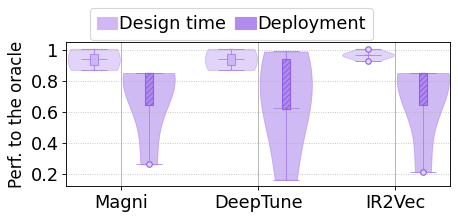

Figure 7(a) C1: thread coarsening. The resulting performance when using an ML model for decision making.


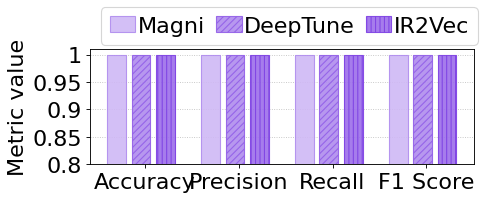

Figure 8(a) C1: thread coarsening. Prom’s performance for detecting drifting samples across case studies and underlying models.


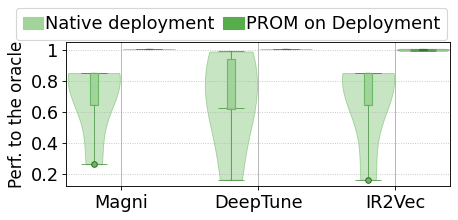

Figure 9(a) C1: thread coarsening. Prom enhances performance through incremental learning in different underlying models.


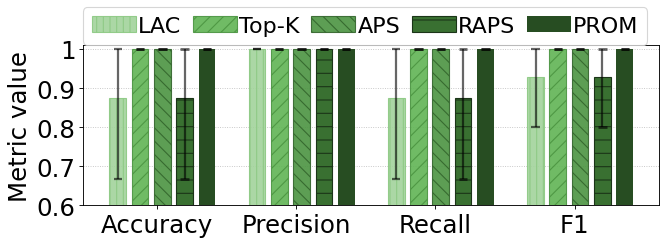

Figure 11(a) C1: Performance of individual nonconformity functions.


In [8]:
%run ae_plot.py --case thread

### Case Study 2: Loop Vectorization (Section 6.2)

This task constructs a predictive model to determine the optimal Vectorization Factor (VF) and Interleaving Factor (IF) for individual  vectorizable loops in C programs [34, 48]. Following [34], we ex-  plore 35 combinations of VF (1, 2, 4, 8, 16, 32, 64) and IF (1, 2, 4, 8, 16). We initially allocate 80% of loop programs for training the model, reserving the remaining 20% for testing its performance. To introduce data drift, we  use loop programs generated from 14 benchmarks for training  and evaluate the model on the programs from the remaining 4 benchmarks. This ensures that the function and content of test  samples are not encountered during the training phase.

This demo corresponds to Figure 7(b), 8(b), 9(b) and 11(b) of the submitted manuscript.

*approximate runtime = 10 minutes*


In [9]:
!python ae_loop.py


The evaluation on DeepTune

_________Start training phase________
Loading dataset
Training underlying model...
Training successful, the speedup is 0.7989800681029076
_________Start deploy phase________
Loading dataset
Loading underlying model...
Loading model successful, the speedup during deployment is 0.6577737847015122
Start conformal prediction...
_____________The detection performance can be seen below_____________
The accuracy for detection on lac is: 98.50%, precision is: 100.00%, recall is: 98.50%, F1 is: 99.24%
The accuracy for detection on top_k is: 0.00%, precision is: 0.00%, recall is: 0.00%, F1 is: 0.00%
The accuracy for detection on aps is: 19.00%, precision is: 100.00%, recall is: 19.00%, F1 is: 31.93%
The accuracy for detection on raps is: 0.00%, precision is: 0.00%, recall is: 0.00%, F1 is: 0.00%
The accuracy for detection on mixture is: 99.50%, precision is: 100.00%, recall is: 99.50%, F1 is: 99.75%
The PROM detection performance is: the accuracy is: 99.50%, the prec

## Full-scale evaluation data

We now plot the diagrams using full-scale evaluation data. 
The results correspond to Figure 7(b), 8(b), 9(b) and 11(b) of the submitted manuscript.

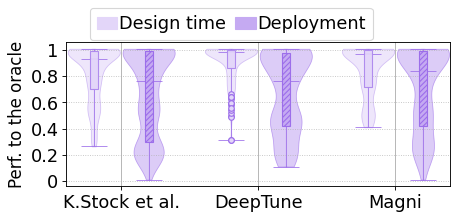

Figure 7(b) C2: loop vectorization. The resulting performance when using an ML model for decision making.


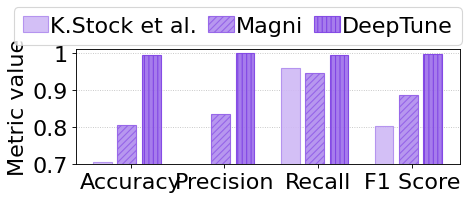

Figure 8(b) C2: loop vectorization. Prom’s performance for detecting drifting samples across case studies and underlying models.


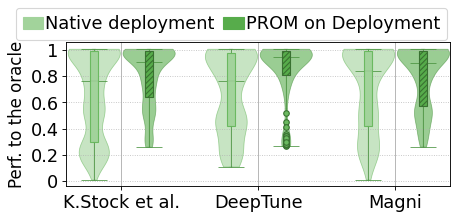

Figure 9(b) C2: loop vectorization. Prom enhances performance through incremental learning in different underlying models.


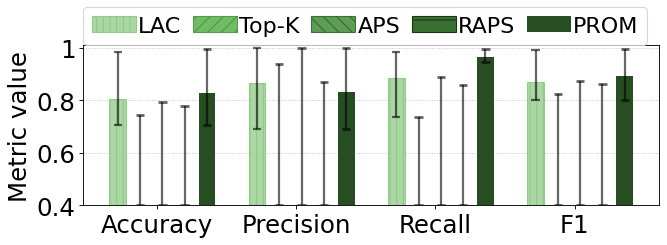

Figure 11(b) C2: loop vectorization. Performance of individual nonconformity functions.


In [10]:
%run ae_plot.py --case loop

### Case Study 3: Heterogeneous Mapping (Section 6.3)

This task develops a binary classifier to determine whether the CPU or  the GPU gives faster performance for an OpenCL kernel. We train and evaluate the baseline  model using 10-fold cross-validation. This involves training a model on programs from all but one of the sets and then testing it on the programs from the remaining set. To introduce data drift, we train the models using 6 benchmark suites and then test the trained  models on the remaining suite. We repeat this process until all  benchmark suites have been tested at least once.

This demo corresponds to Figure 7(c), 8(c), 9(c) and 11(c) of the submitted manuscript.

*approximate runtime = 20 minutes*

In [11]:
import os

target_directory = os.path.abspath("../case_study/DeviceM/")
target_file = "ae_dev.sh"
if not os.path.isfile(target_file):
    os.chdir(target_directory)
    print(f"Switched to directory: {target_directory}")


!bash ae_dev.sh

if os.path.isfile(target_file):
    os.chdir("../../tutorial")

Switched to directory: /cgo/prom/PROM/examples/case_study/DeviceM

The evaluation on Instruct2vec

_________Start training phase________
Start training...
The Training performance is: 0.9000208185635654
_________Start deployment phase________
Loading dataset and underlying model...
The performance of underlying model during deployment phase is 0.7131319119050349
Start conformal prediction on amd...
_____________The detection performance can be seen below_____________
The accuracy for detection on lac is: 52.08%, precision is: 52.08%, recall is: 100.00%, F1 is: 68.49%
The accuracy for detection on top_k is: 52.08%, precision is: 52.08%, recall is: 100.00%, F1 is: 68.49%
The accuracy for detection on aps is: 52.08%, precision is: 52.08%, recall is: 100.00%, F1 is: 68.49%
The accuracy for detection on raps is: 52.08%, precision is: 52.08%, recall is: 100.00%, F1 is: 68.49%
The accuracy for detection on mixture is: 52.08%, precision is: 52.08%, recall is: 100.00%, F1 is: 68.49%
The PROM de

## Full-scale evaluation data

We now plot the diagrams using full-scale evaluation data. 
The results correspond to Figure 7(c), 8(c), 9(c) and 11(c) of the submitted manuscript.

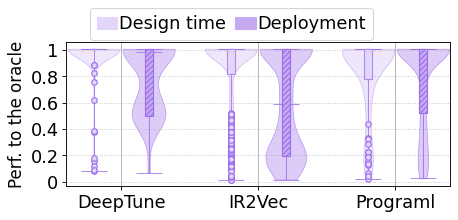

Figure 7(d) C3: heterogeneous mapping. The resulting performance when using an ML model for decision making.


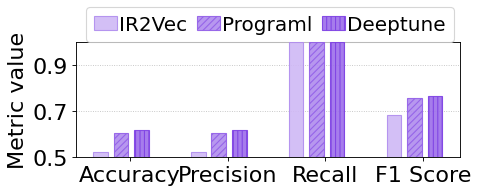

Figure 8(d) C3: heterogeneous mapping. Prom’s performance for detecting drifting samples across case studies and underlying models.


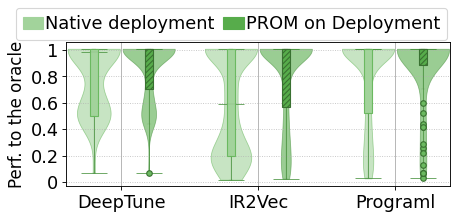

Figure 9(d) C3: heterogeneous mapping. Prom enhances performance through incremental learning in different underlying models.


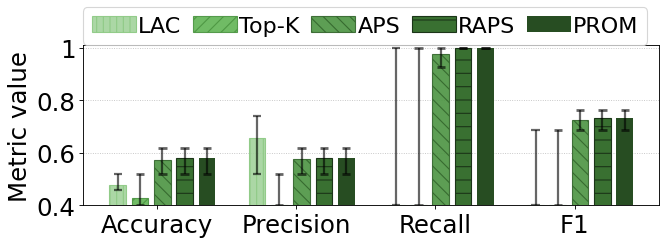

Figure 11(d) C3: heterogeneous mapping. Performance of individual nonconformity functions.


In [23]:
%run ae_plot.py --case dev

### Case Study 4: Vulnerability Detection (Section 6.4)

This task develops an ML classifier to predict if a given C function  contains a potential code vulnerability.

This demo corresponds to Figure 7(d), 8(d), 9(d) and 11(d) of the submitted manuscript. We consider the top-8 most dangerous types of bugs from the 2023 CWE. As with prior approaches, we initially train the  model on 80% of the randomly selected samples and evaluate its  performance on the remaining 20% samples. Then, we introduce  data drift by training the model on data collected between 2013 and 2023 and testing the trained model on samples collected between 2021 and 2023.

*approximate runtime = 30 minutes*

In [13]:
!python ae_vul.py --output_dir=./saved_models     --model_type=roberta     --tokenizer_name=microsoft/codebert-base     --model_name_or_path=microsoft/codebert-base   --do_train  --do_eval     --do_test     --train_data_file=../../benchmark/Bug/train.jsonl     --eval_data_file=../../benchmark/Bug/valid.jsonl     --test_data_file=../../benchmark/Bug/test.jsonl --evaluate_during_training



Case 4:


--- The Evaluation on CodeBERT ---

_________Start training phase________
dataset partition...
Extracting features...
Training the underlying model...
The best accuracy of trained model is: 0.875
_________Start deployment phase________
dataset partition...
Extracting features...
Deploy the underlying model...
The current accuracy during deployment is: 0.125
Start the conformal prediction...
Detect the drifting samples...
_____________The detection performance can be seen below_____________
The accuracy for detection on lac is: 84.38%, precision is: 84.38%, recall is: 100.00%, F1 is: 91.53%
The accuracy for detection on aps is: 84.38%, precision is: 84.38%, recall is: 100.00%, F1 is: 91.53%
The accuracy for detection on raps is: 84.38%, precision is: 84.38%, recall is: 100.00%, F1 is: 91.53%
The accuracy for detection on mixture is: 84.38%, precision is: 84.38%, recall is: 100.00%, F1 is: 91.53%
The PROM detection performance is: the accuracy is: 84.38%, the precision is: 84.

## Full-scale evaluation data

We now plot the diagrams using full-scale evaluation data. 
The results correspond to Figure 7(d), 8(d), 9(d) and 11(d) of the submitted manuscript.

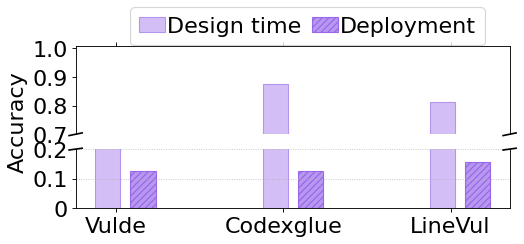

Figure 7(d) C4: vulnerability detection. The resulting performance when using an ML model for decision making.


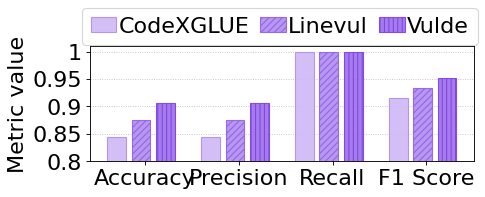

Figure 8(d) C4: vulnerability detection. Prom’s performance for detecting drifting samples across case studies and underlying models.


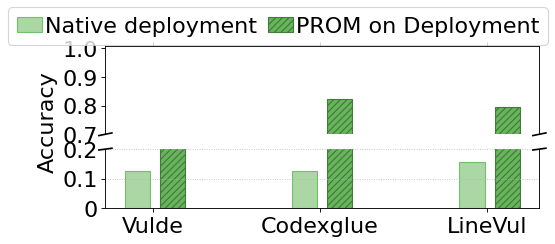

Figure 9(d) C4: vulnerability detection. Prom enhances performance through incremental learning in different underlying models.


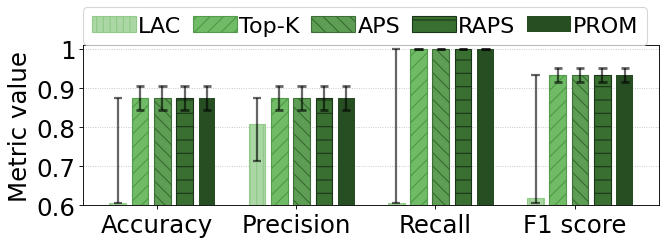

Figure 11(d) C4: vulnerability detection. Performance of individual nonconformity functions.


In [14]:
%run ae_plot.py --case vul

### Case Study 5: DNN Code Generation (Section 6.5)

This task builds a regression-based cost model to drive the schedule  search process in TVM for DNN code generation on multi-core CPUs. The cost model estimates the potential gain of a schedule (e.g., instruction orders and data placement) to guide the search. For the baseline, we train and test the cost model on  the BERT-base dataset, where the model is trained on 80% randomly  selected samples and then tested on the remaining 20% samples. To introduce data drift, we tested the trained model on the other  three variants of the BERT model and ResNet-50.

This demo corresponds to Table 2 of the submitted manuscript.

*approximate runtime = 20 minutes*

In [24]:
!bash ae_tlp.sh

Environment for 'C5' activated.
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject

The evaluation on BERT-base

Load data and split data to train and test...
create folder models/train/tlp_i7_base
^C


## Full-scale evaluation data

We now plot the diagrams using full-scale evaluation data. 
The results correspond to Table 3 and Figure 8(e) of the submitted manuscript.

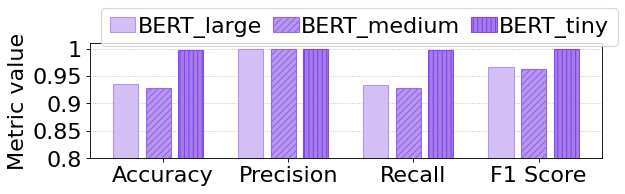

Figure 8(e) C5: DNN code generation. Prom’s performance for detecting drifting samples across case studies and underlying models.
+--------------------------+-------------+-------------+---------------+--------------+
|         Network          |  BERT-base  |  BERT-tiny  |  BERT-medium  |  BERT-large  |
+==========================+=============+=============+===============+==============+
|    Native deployment     |    0.845    |    0.224    |     0.668     |    0.703     |
+--------------------------+-------------+-------------+---------------+--------------+
| PROM assisted deployment |      /      |    0.794    |     0.81      |    0.808     |
+--------------------------+-------------+-------------+---------------+--------------+
 Table 3. C5: DNN code generation (performance to the oracle ratio) - trained on BERT-base and tested on BERT variants.


In [16]:
%run ae_plot.py --case tlp

### Compare to Other CP-based Methods (Section 7.5)

This experiment compares Prom with conformal prediction-based methods like MAPIE and PUNCC, as well as RISE, developed for wireless sensing, and TESSERACT, designed for malware classification.

In [17]:
# The results correspond to Figure 10.
!bash ae_compare.sh


Case 1:


--- Comparison Evaluation: DeepTune ---

_________Start training phase________
Loading dataset...
Training underlying model...
Training model successful, the speedup is 93.14%
Training phase finished. The speedup percentage is: 0.93
_________Start deploy phase________
Loading dataset...
Loading underlying model...
Loading successful, the speedup during deployment is 78.43%
Start conformal prediction...
_____________The MAPIE-PUNCC detection performance can be seen below_____________
The accuracy is: 100.00%, the precision is: 100.00%, the recall is: 100.00%, the F1 is: 100.00%
______________________________________
_____________The RISE detection performance can be seen below_____________
The accuracy is: 100.00%, the precision is: 100.00%, the recall is: 100.00%, the F1 is: 100.00%
______________________________________
_____________The TESSERACT detection performance can be seen below_____________
The accuracy is: 100.00%, the precision is: 100.00%, the recall is: 100.00%,

The training performance is: 0.8339660097120907
_________Start deploy phase________
Load dataset...
Load the underlying model...
Processing LLVMGraphBuilder-LLVMProGraMLVisitor-GnnPytorchGeomModel
Suceessfully
Extract the features...
Processing LLVMGraphBuilder-LLVMProGraMLVisitor-GnnPytorchGeomModel
Test the model...
The underlying model performance during deployment to oracle is: 0.5820
Conformal prediction...
_____________The MAPIE-PUNCC detection performance can be seen below_____________
The accuracy is: 38.35%, the precision is: 100.00%, the recall is: 0.28%, the F1 is: 0.56%
______________________________________
_____________The RISE detection performance can be seen below_____________
The accuracy is: 46.58%, the precision is: 64.29%, the recall is: 30.59%, the F1 is: 41.46%
______________________________________
_____________The TESSERACT detection performance can be seen below_____________
The accuracy is: 46.58%, the precision is: 79.27%, the recall is: 18.41%, the F1 is: 2

## Full-scale evaluation data

We now plot the diagrams using full-scale evaluation data. 
The results correspond to Figure 10 of the submitted manuscript.

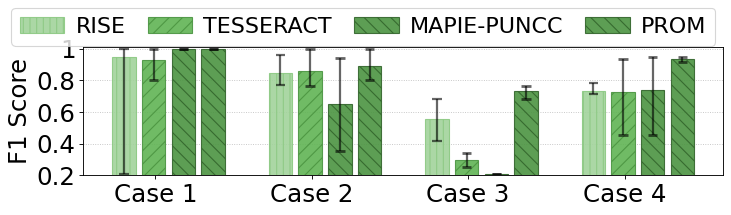

Figure 10:  Geometric mean and variances across models of the F1 score in classification tasks.


In [18]:
%run ae_plot.py --case compare

##  Further Analysis (Optional)

This section presents an analysis of certain parameters, corresponding to Section 7.6.

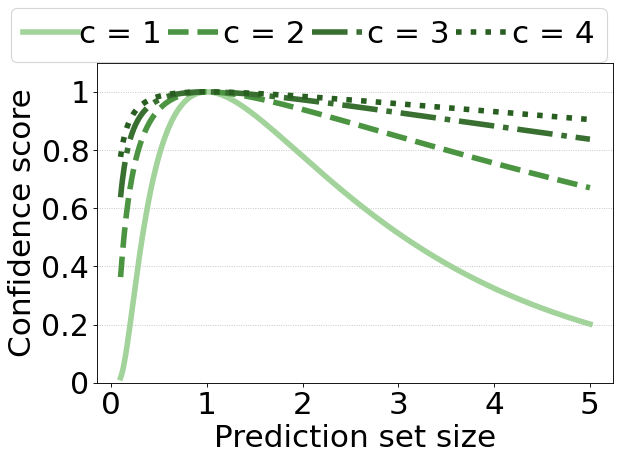

13 (a): Prom performance as Gaussian scale parameter changes.


In [19]:
# The results correspond to Figure 13(a).
%run ae_plot.py --case gaussian

In [20]:
# The results correspond to Figure 13(b).
!bash ae_cd.sh


The coverage deviation evaluation on DeepTune

_________Start training phase________
Loading dataset...
Training underlying model...
Training model successful, the speedup is 93.14%
Training phase finished. The speedup percentage is: 0.93
_________Start deploy phase________
Loading dataset...
Loading underlying model...
Loading successful, the speedup during deployment is 78.43%
Start conformal prediction...
The coverage deviation is: 0.050
______________________________________

The coverage deviation evaluation on Magni

_________Start training phase________
Loading dataset...
Training underlying model...
The time about the training model: 0.30623602867126465 s
Training model successful, the speedup is 93.14%
Training phase finished. The speedup percentage is: 0.93
_________Start deploy phase________
Loading dataset...
Loading underlying model...
Loading successful, the speedup during deployment is 75.32%
Start conformal prediction...
The coverage deviation is: 0.050
_______________

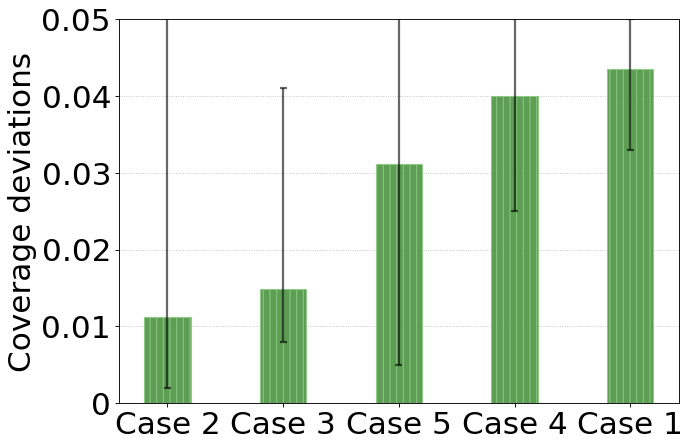

Figure 13 (b): Coverage deviations across 5 case studies


In [21]:
%run ae_plot.py --case cd

In [22]:
# clean all temporary files
!bash ae_clean.sh